In [ ]:
import StringIO
import cv2
import Image
import numpy as np
#http://answers.opencv.org/question/63847/how-to-extract-tables-from-an-image/

In [ ]:
#load source image
filename = "//home//kgplatformuser//python//ocr//samples//Results//PDFImages//PO10_Cropped_CroppedExPgsRmvd_1.png"
img = cv2.imread(filename,0)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


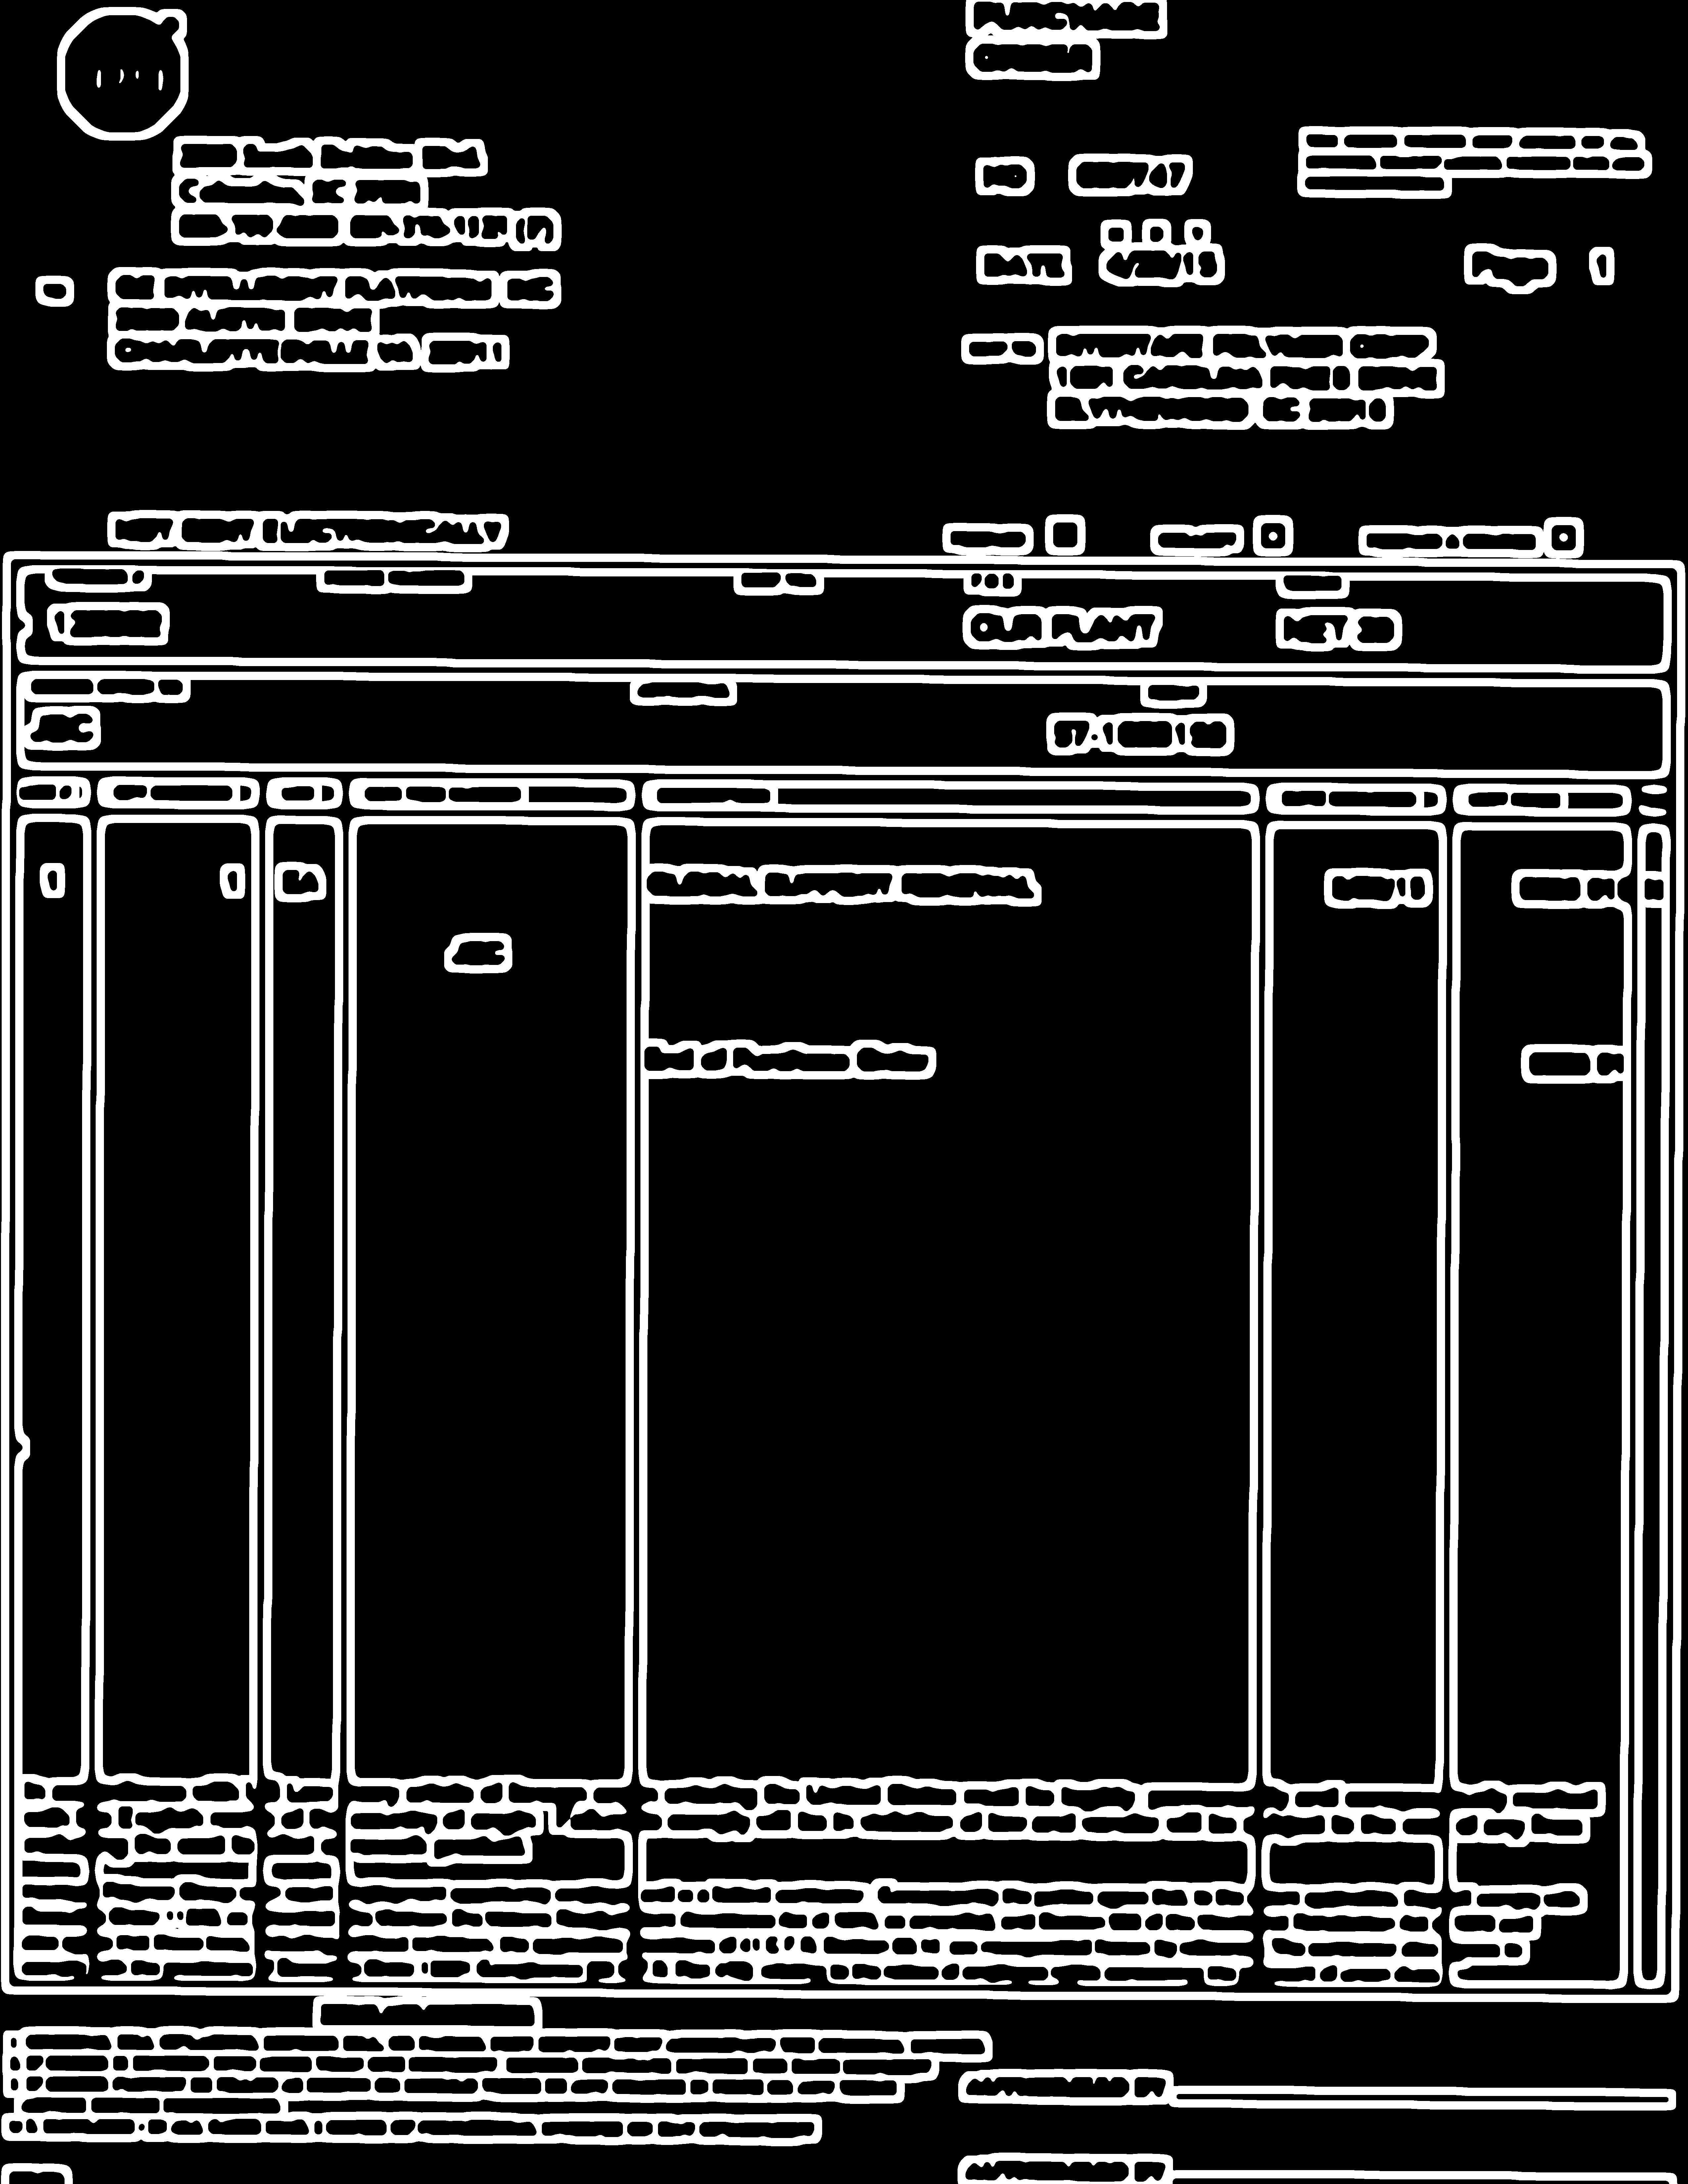

In [122]:
#apply adptive threashold at the bitwsise not of gray 
    # Set thresholds
img = OTSUBin('' ,img,bluriter=3, blursig = 33 )
th1 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,51,-2)
_,th2 = cv2.threshold(th1,15,255,cv2.THRESH_BINARY)

#final=cv2.medianBlur(th2,15)
blur = cv2.bilateralFilter(blur,11,75,75)

imgpic = Image.fromarray(th2, mode = 'L')
#imgpic = Image.fromarray(th2, mode = 'L')
imgpic


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


True

In [ ]:
#create 2 clones of inverted image to store vertical and horizontal lines
horizontal = blur.copy()
vertical = blur.copy()



In [123]:
#specify size on the horizonal axis  
scale = 2
height, width = horizontal.shape
horizontalsize = int(width/scale)
horizontalsize

2550

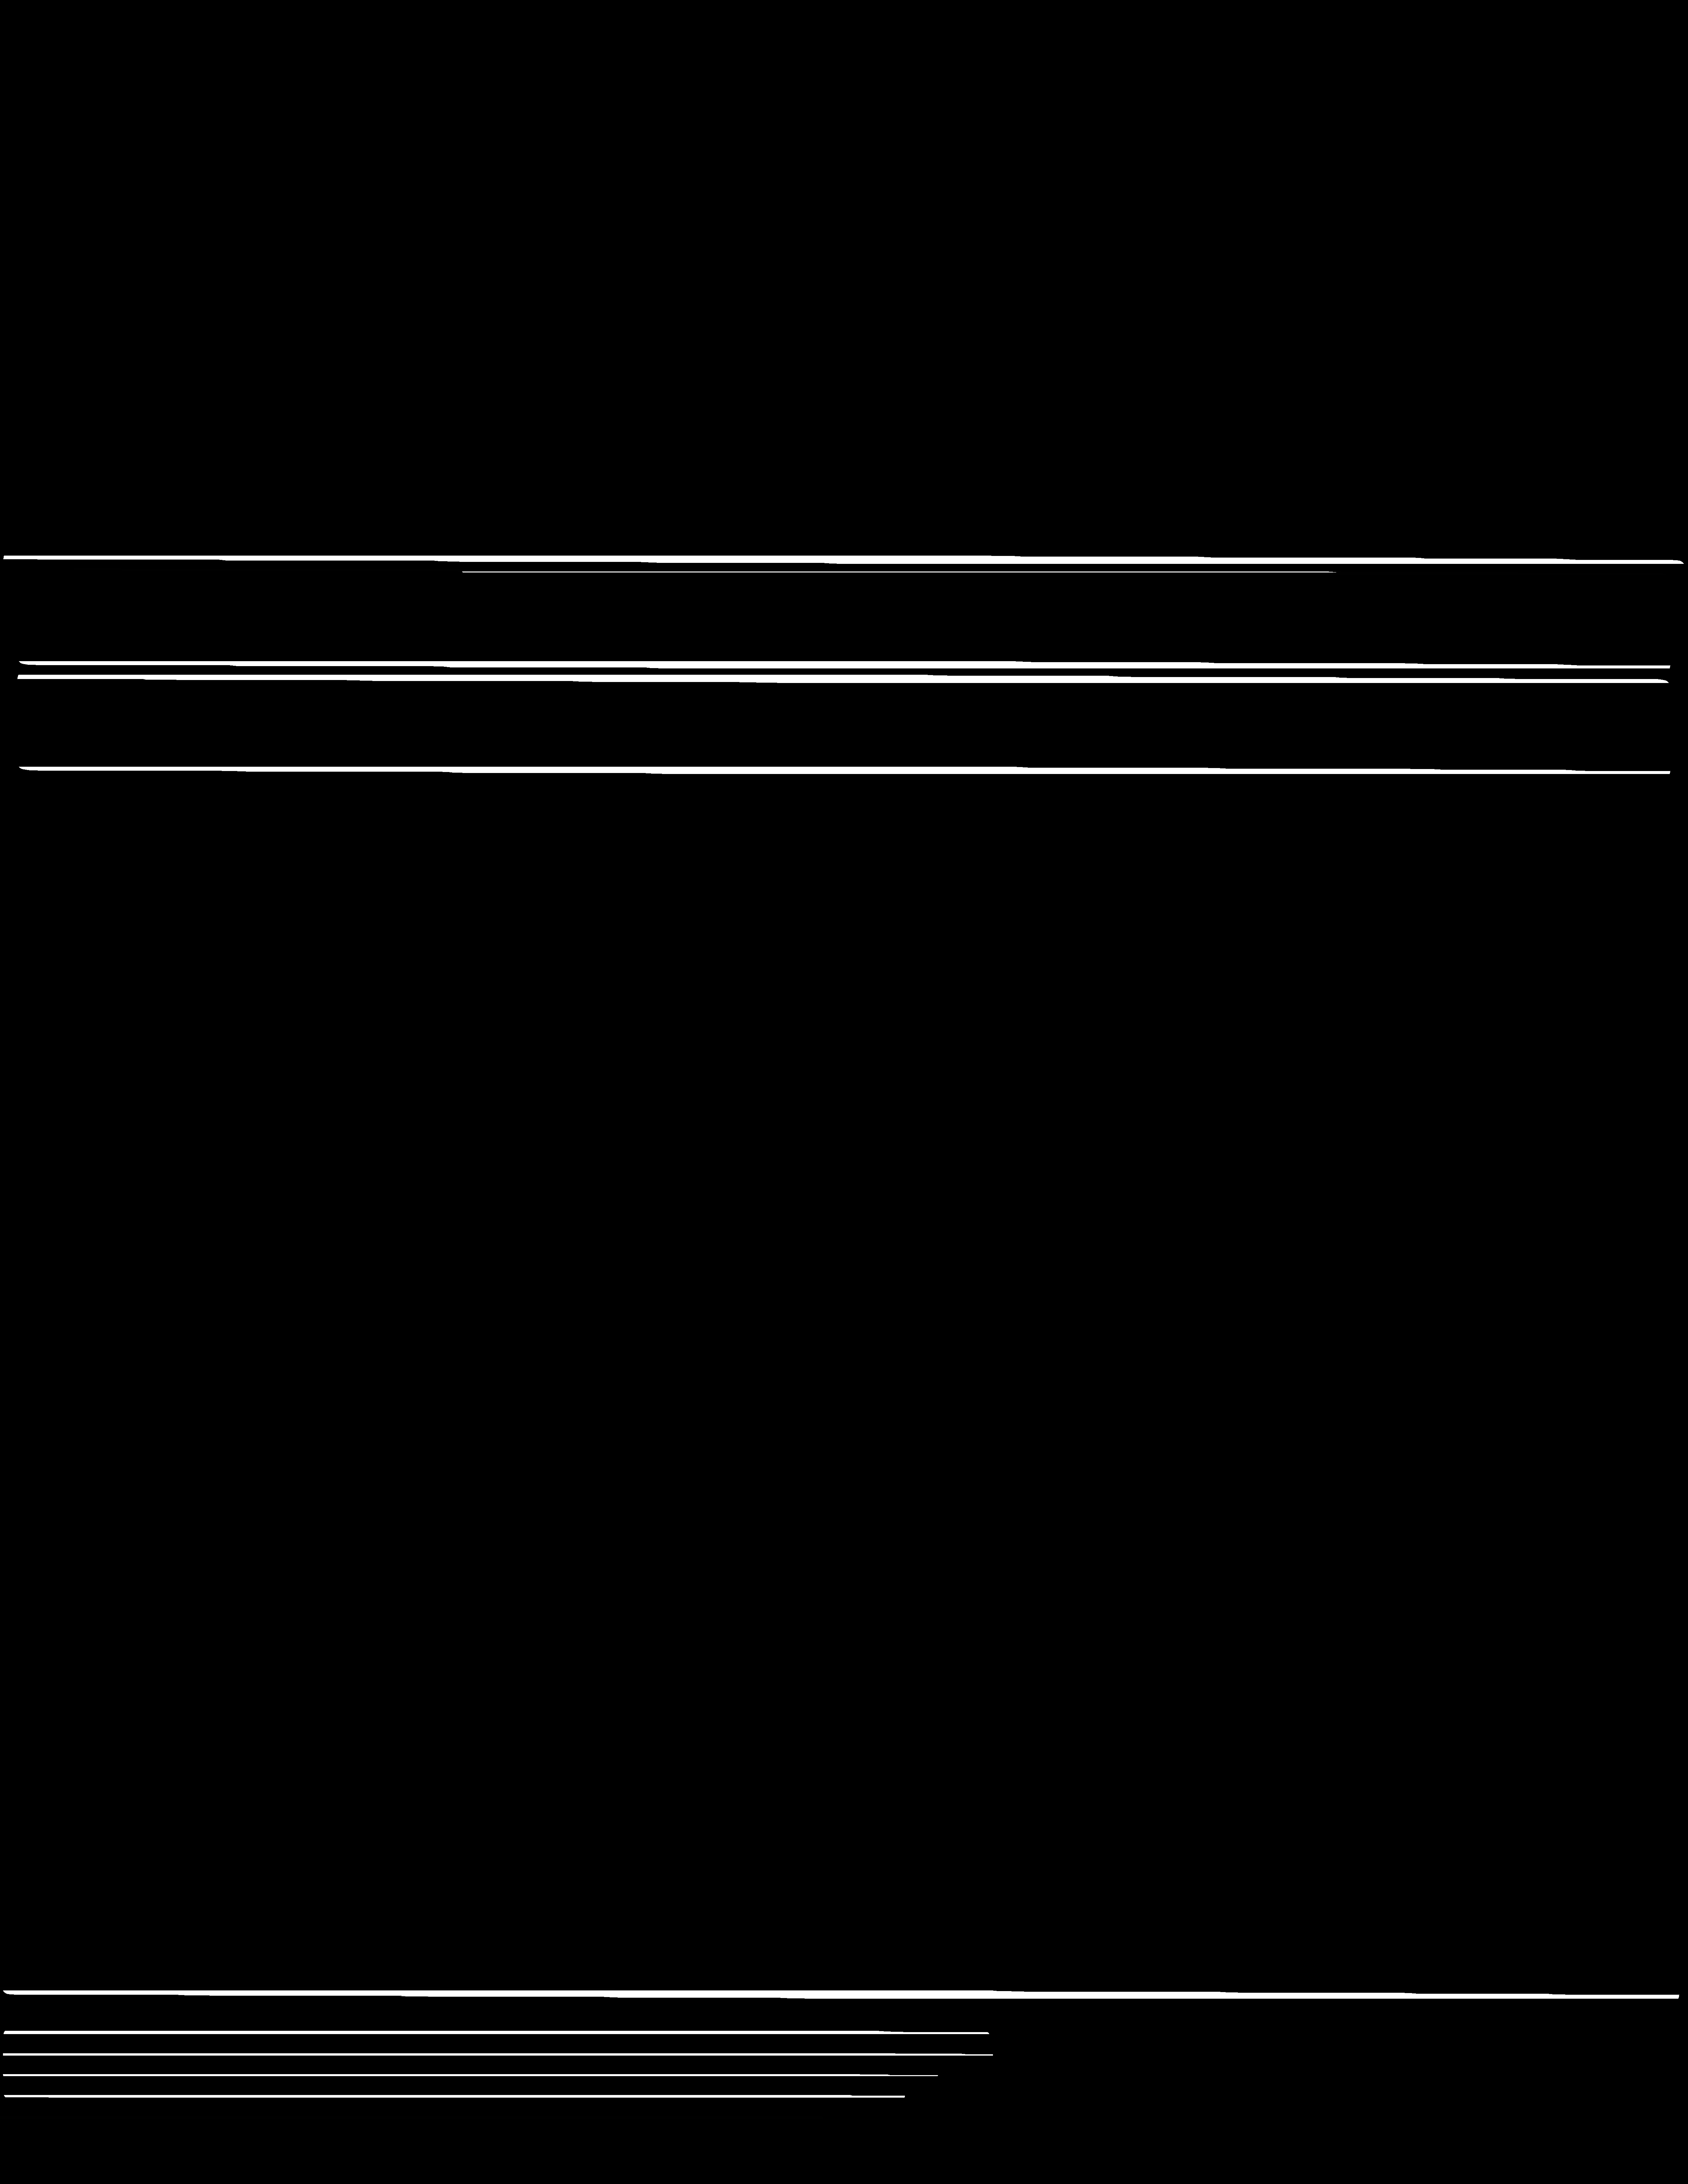

In [124]:
#Create structure element for extracting horizontal lines through morphology operations
#Note: The kernal will have dimensions of a horizontal 1D vector, this is used to represent the horizontal line kernal (as a line is a 1D object of some specified length)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(horizontalsize,1))
horizontal = cv2.erode(horizontal,kernel,iterations = -1)
horizontal = cv2.dilate(horizontal,kernel,iterations = -1)

#show image
imgpic = Image.fromarray(horizontal)
imgpic



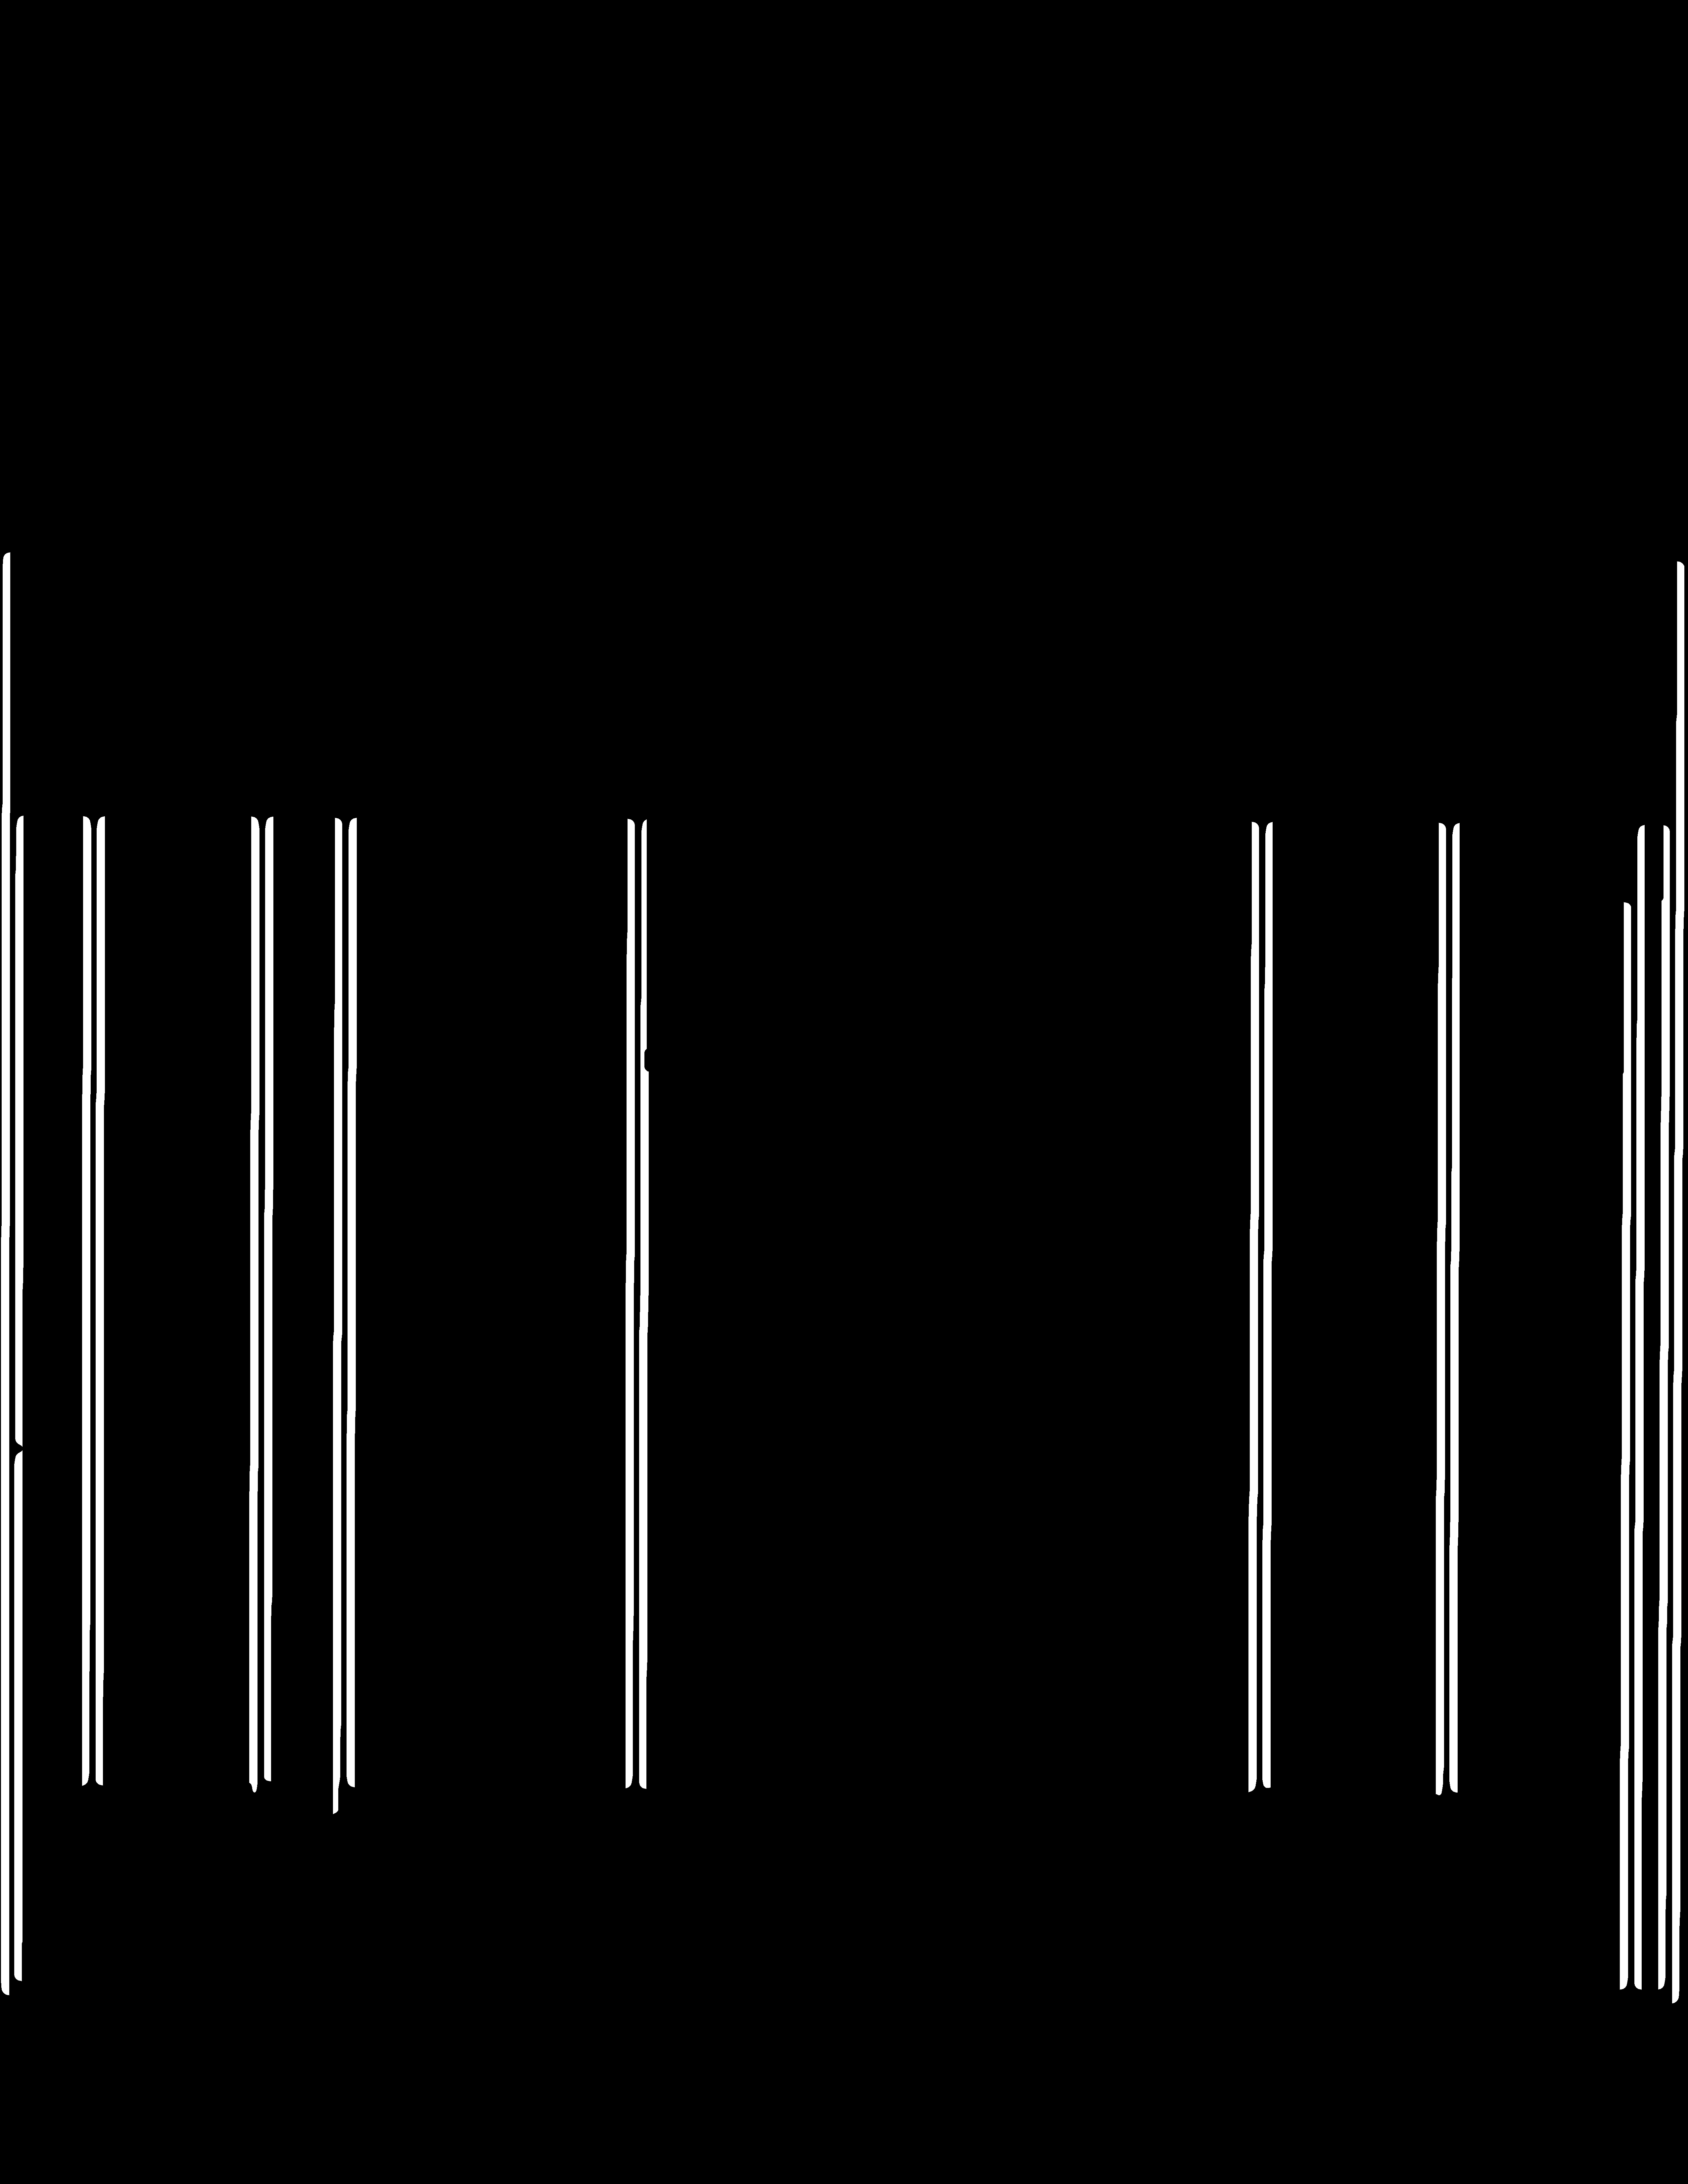

In [127]:
#do the same for vertical 
#specify size on the horizonal axis  
scale = 30
height, width = vertical.shape
verticalsize = int(height/scale)
verticalsize

#Create structure element for extracting horizontal lines through morphology operations
#Note: The kernal will have dimensions of a horizontal 1D vector, this is used to represent the horizontal line kernal (as a line is a 1D object of some specified length)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1,verticalsize))
vertical = cv2.erode(vertical,kernel,iterations = -1)
vertical = cv2.dilate(vertical,kernel,iterations = -1)

imgpic = Image.fromarray(vertical)
imgpic


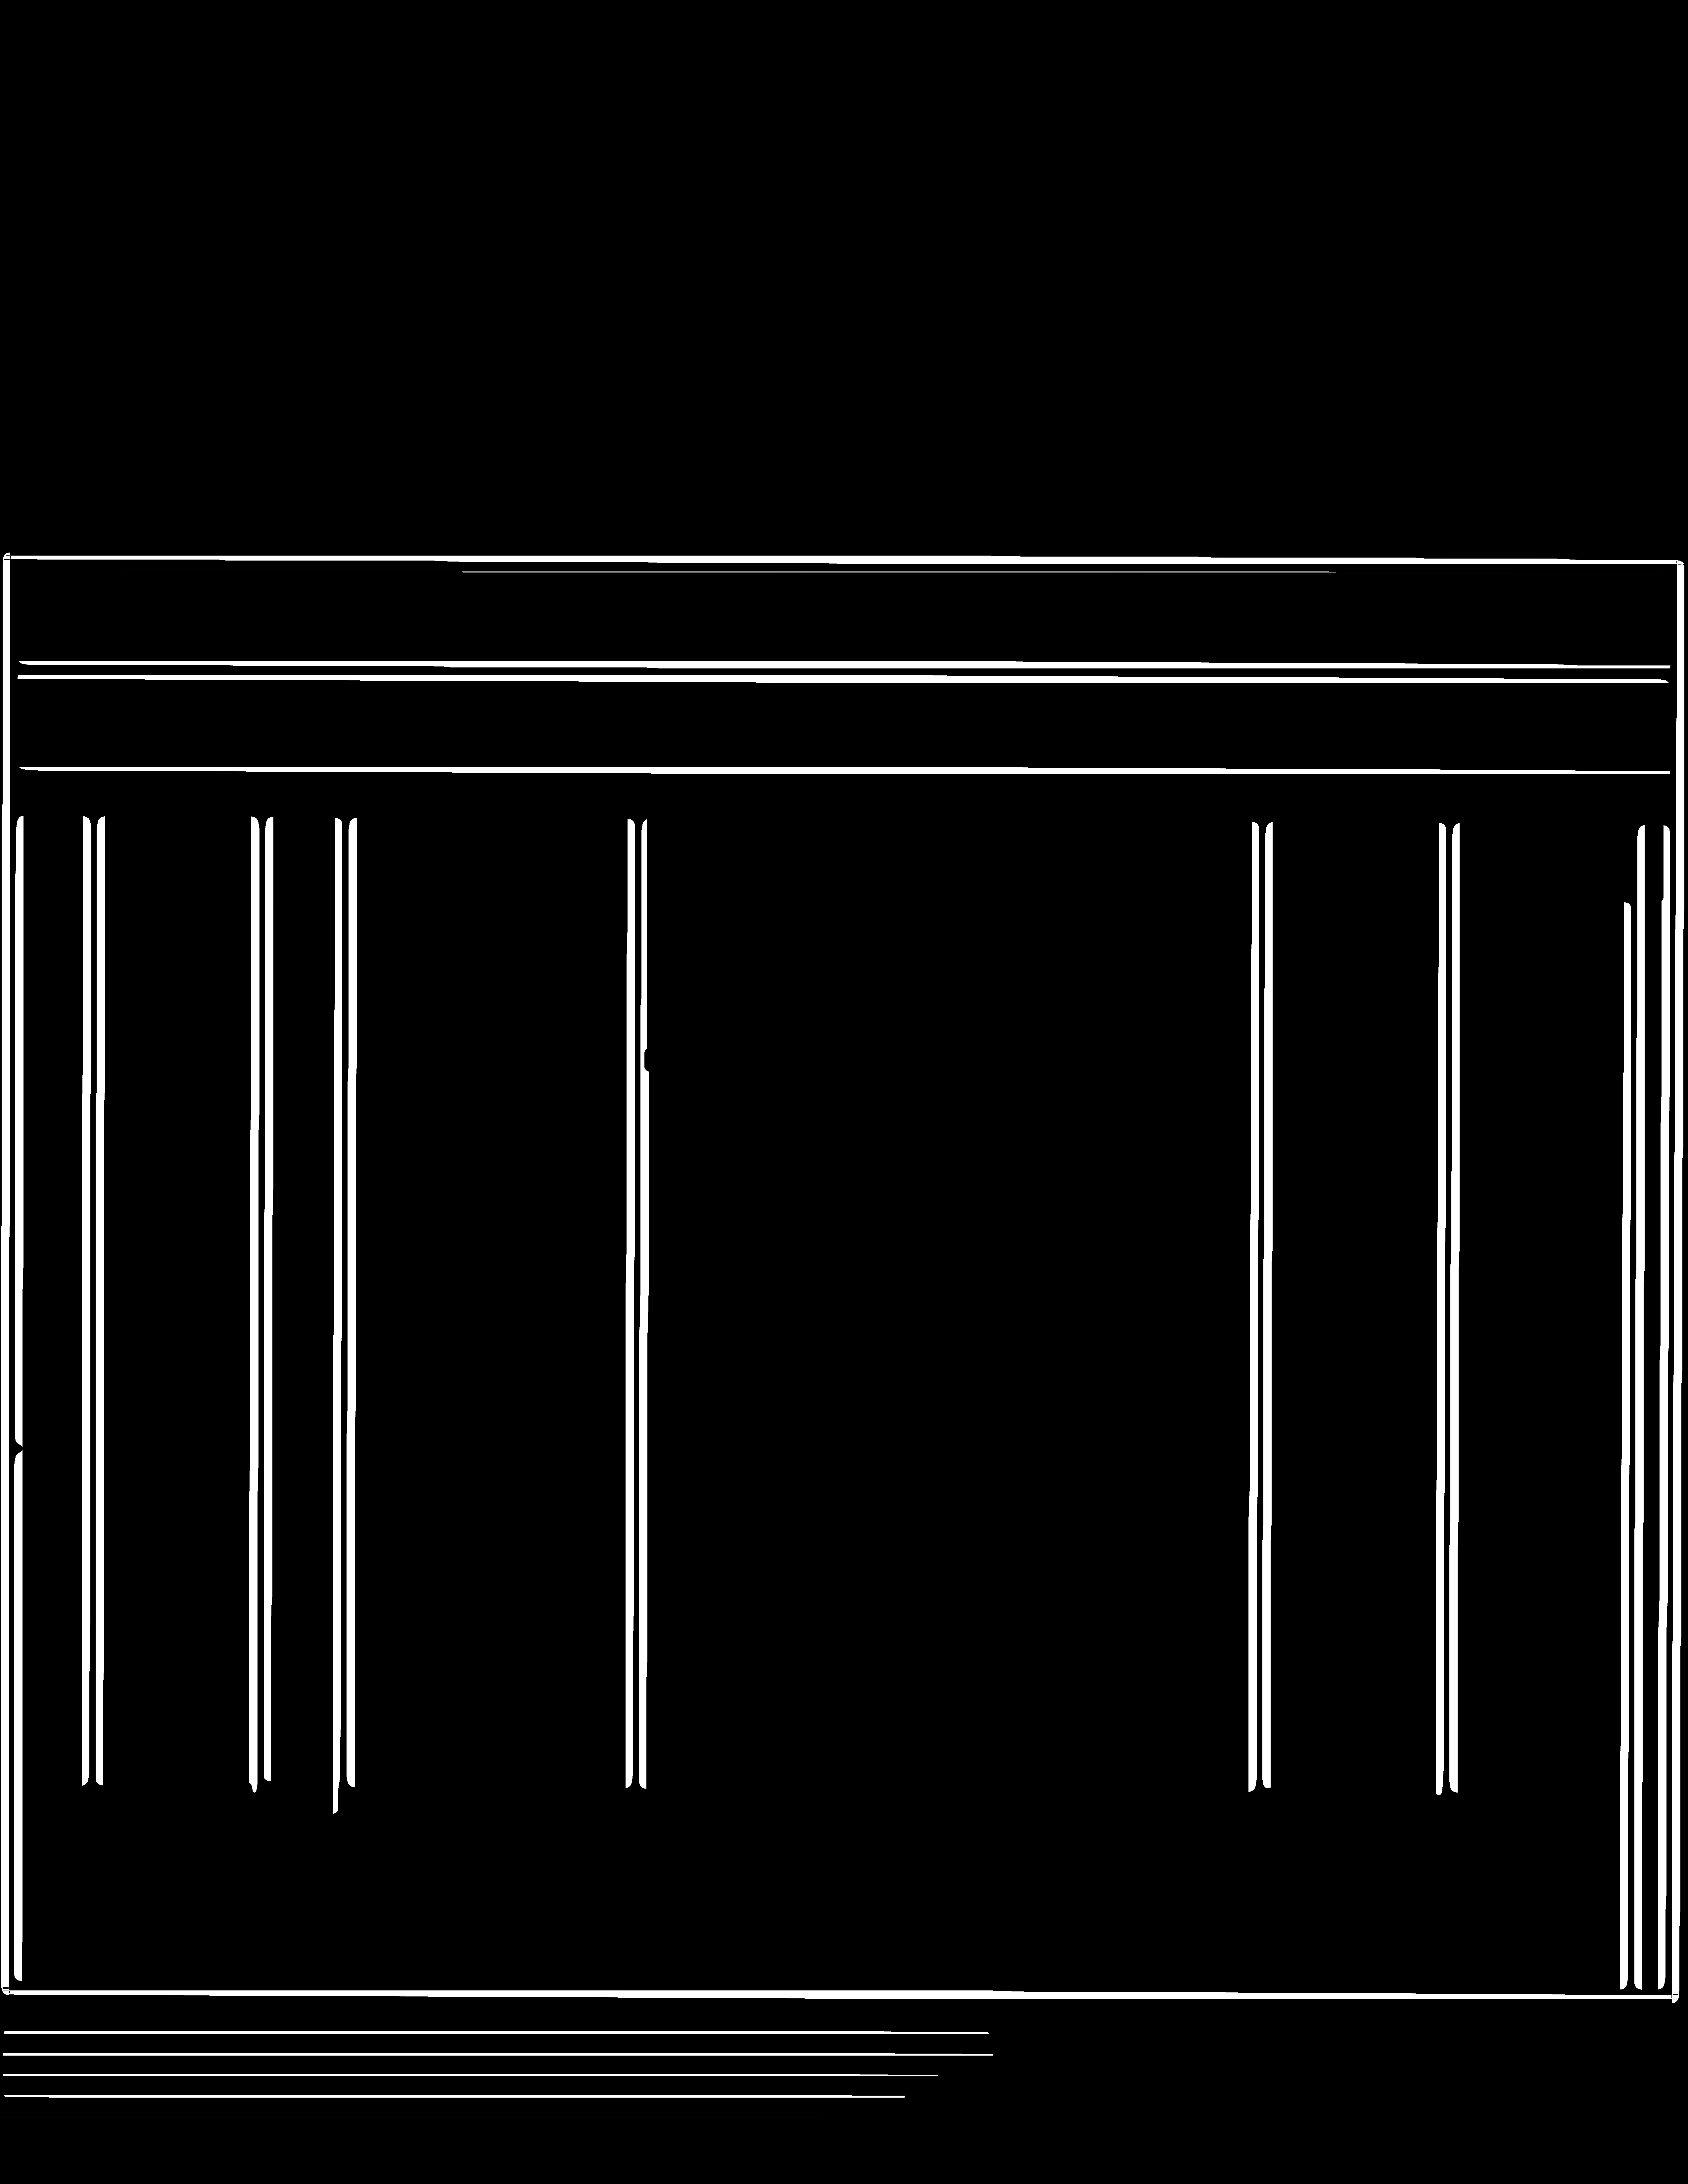

In [162]:
#show combined 
grid = horizontal + vertical 
grid

#notice we dont get the result we need, our vertical lines are not getting picked up
imgpic = Image.fromarray(grid)
imgpic

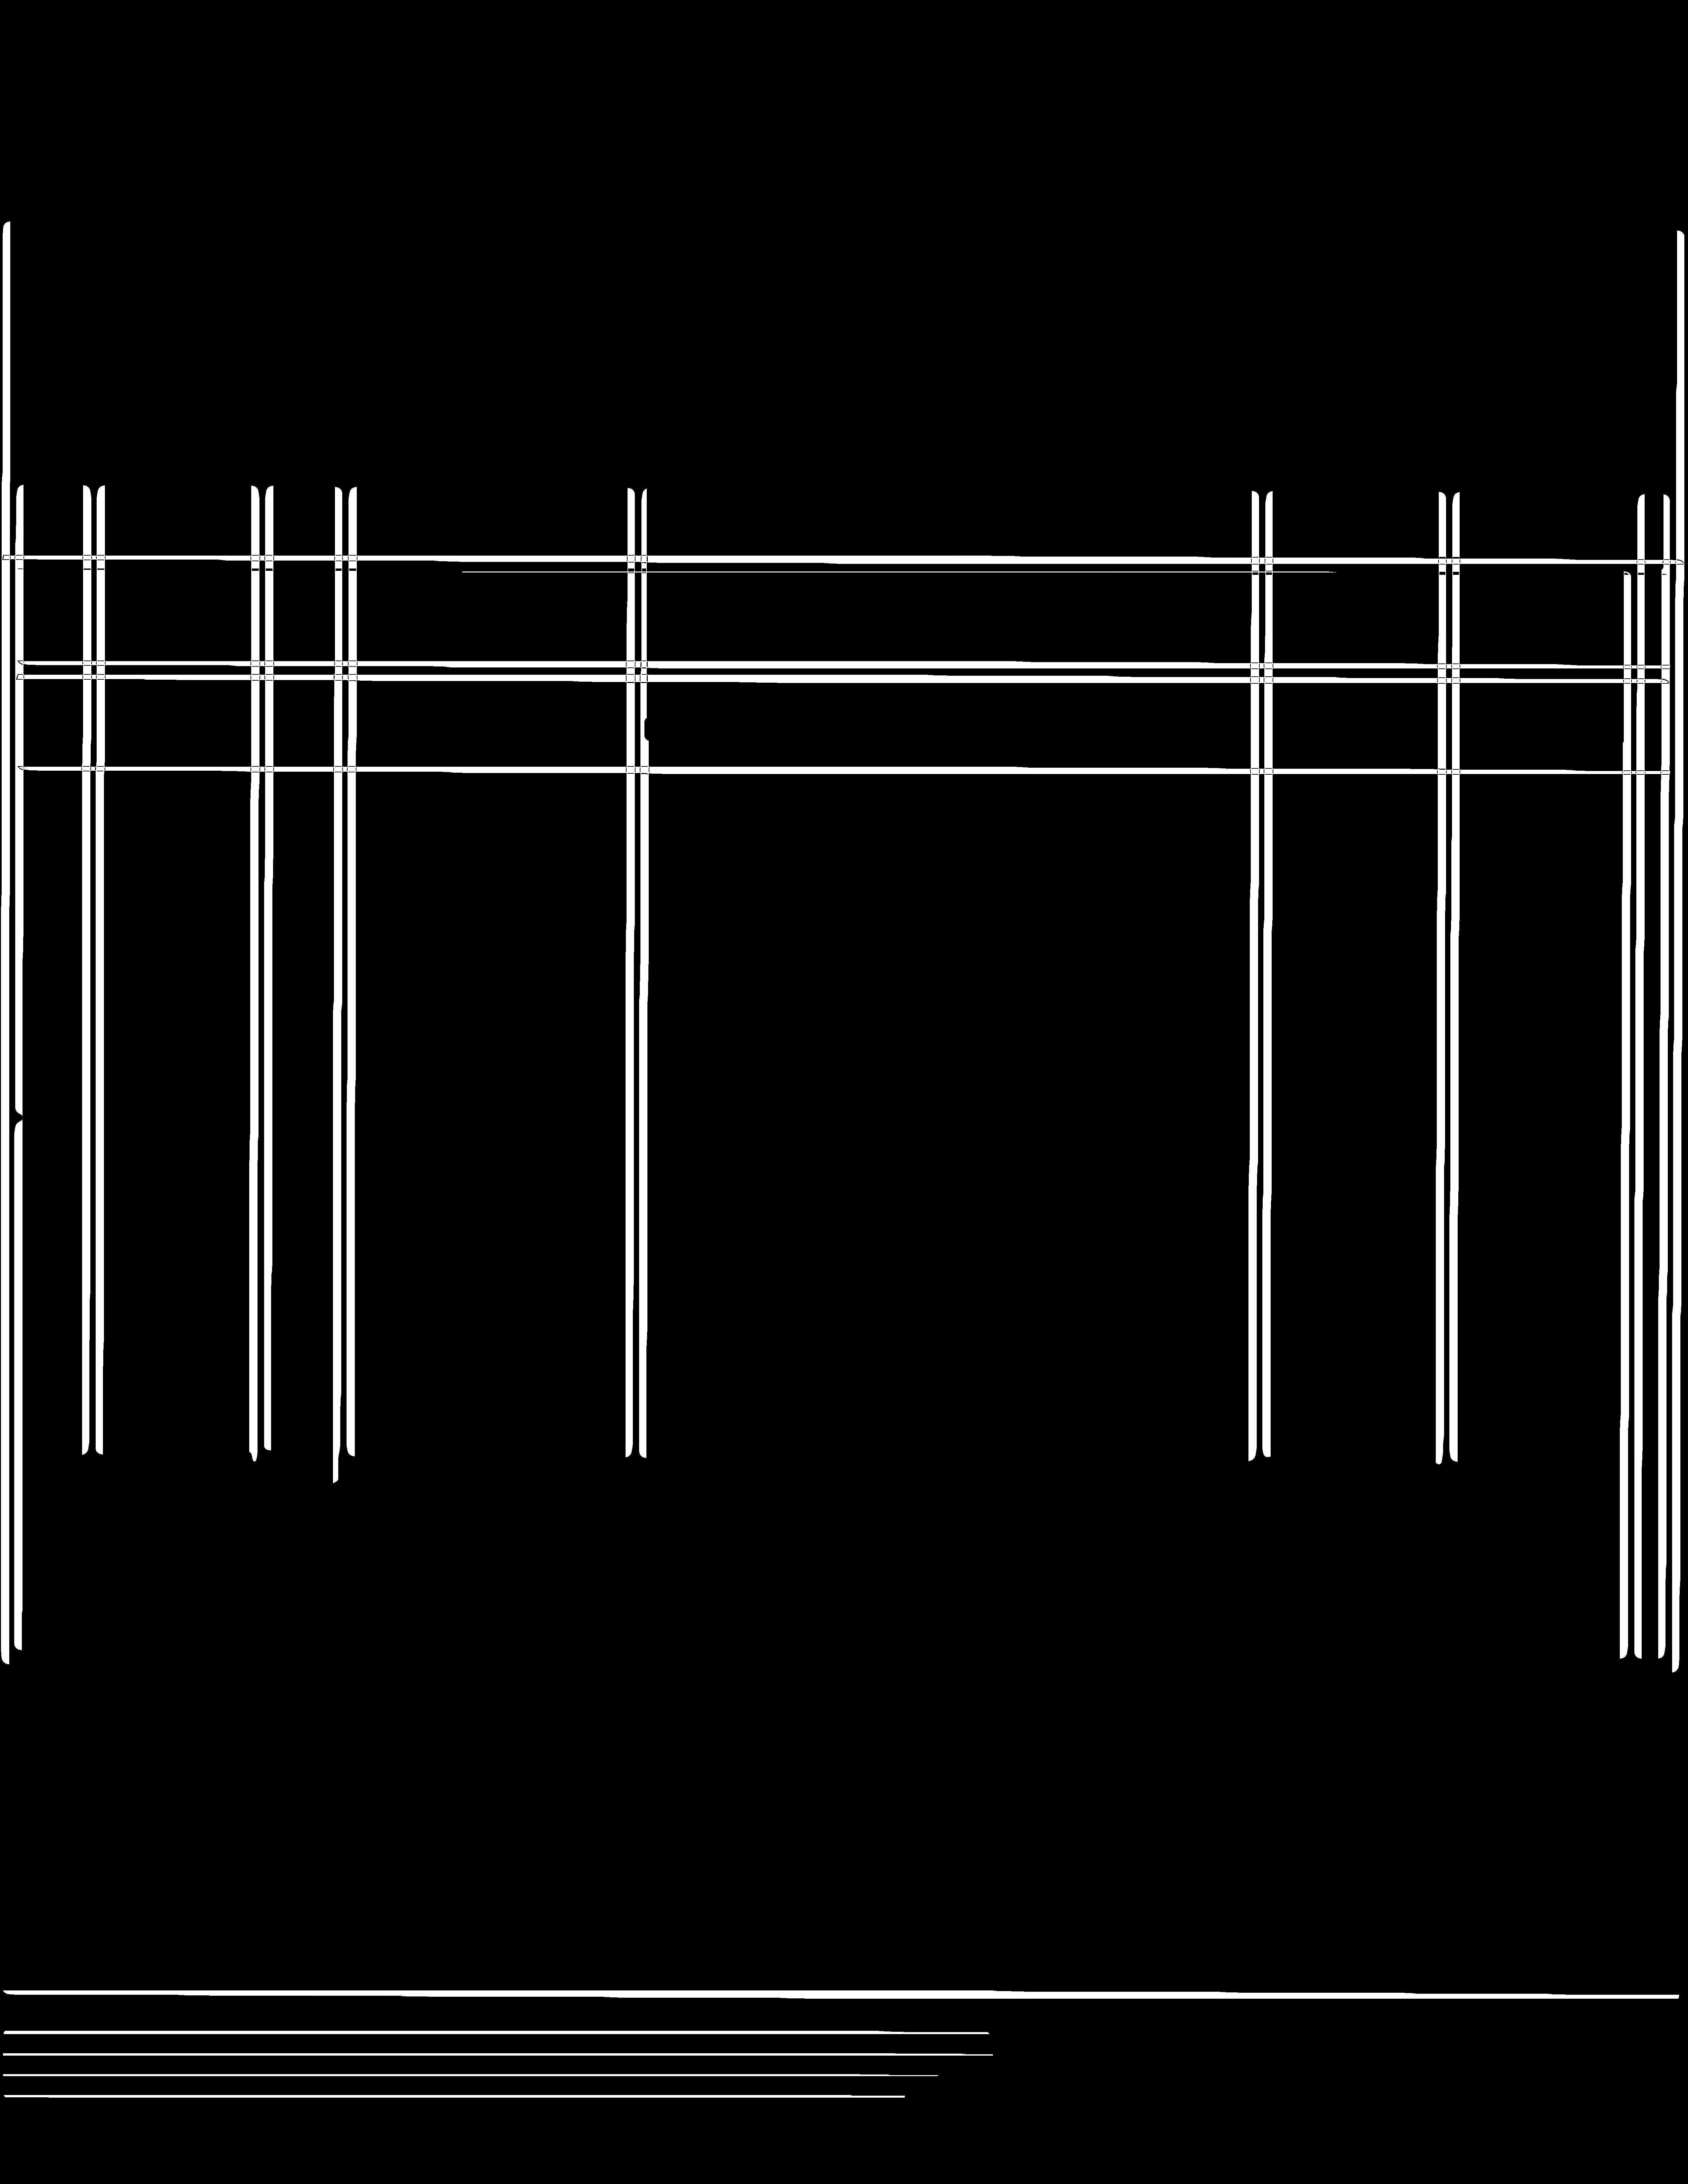

In [159]:
#offset the original vertical lines, and retrace image 

import PIL 
from PIL import ImageChops
imgpic = Image.fromarray(vertical, mode='L')
newvert = PIL.ImageChops.offset(imgpic, xoffset=0, yoffset=-1000)
newvert.save('newvert.png')

img =  cv2.imread('newvert.png',0)
im = np.array(img)

grid = horizontal + im
imgpic = Image.fromarray(grid)
imgpic


In [165]:
##find the joints between the lines of the tables, we will use this information in order to descriminate tables from pictures (tables will contain more than 4 joints while a picture only 4 (i.e. at the corners))

clean = cv2.bitwise_and(horizontal,newvert,mask = joints)
imshow("joints", joints);

TypeError: src2 is not a numpy array, neither a scalar

In [ ]:
#TRY TO SAVE THE OUTPUT FROM ABOVE, and TRAIN A MODEL TO IDENTIFY SILMILAR SHAPES 
#https://stackoverflow.com/questions/27969091/processing-an-image-of-a-table-to-get-data-from-it
import cv2
import numpy as np
import os

# the list of images (tables)
images = ['table1.png', 'table2.png', 'table3.png', 'table4.png', 'table5.png']

# the list of templates (used for template matching)
templates = ['train1.png']

def remove_duplicates(lines):
    # remove duplicate lines (lines within 10 pixels of eachother)
    for x1, y1, x2, y2 in lines:
        for index, (x3, y3, x4, y4) in enumerate(lines):
            if y1 == y2 and y3 == y4:
                diff = abs(y1-y3)
            elif x1 == x2 and x3 == x4:
                diff = abs(x1-x3)
            else:
                diff = 0
            if diff < 10 and diff is not 0:
                del lines[index]
    return lines


def sort_line_list(lines):
    # sort lines into horizontal and vertical
    vertical = []
    horizontal = []
    for line in lines:
        if line[0] == line[2]:
            vertical.append(line)
        elif line[1] == line[3]:
            horizontal.append(line)
    vertical.sort()
    horizontal.sort(key=lambda x: x[1])
    return horizontal, vertical


def hough_transform_p(image, template, tableCnt):
    # open and process images
    img = cv2.imread('imgs/'+image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # probabilistic hough transform
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 200, minLineLength=20, maxLineGap=999)[0].tolist()

    # remove duplicates
    lines = remove_duplicates(lines)

    # draw image
    for x1, y1, x2, y2 in lines:
        cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 1)

    # sort lines into vertical & horizontal lists
    horizontal, vertical = sort_line_list(lines)

    # go through each horizontal line (aka row)
    rows = []
    for i, h in enumerate(horizontal):
        if i < len(horizontal)-1:
            row = []
            for j, v in enumerate(vertical):
                if i < len(horizontal)-1 and j < len(vertical)-1:
                    # every cell before last cell
                    # get width & height
                    width = horizontal[i+1][1] - h[1]
                    height = vertical[j+1][0] - v[0]

                else:
                    # last cell, width = cell start to end of image
                    # get width & height
                    width = tW
                    height = tH
                tW = width
                tH = height

                # get roi (region of interest) to find an x
                roi = img[h[1]:h[1]+width, v[0]:v[0]+height]

                # save image (for testing)
                dir = 'imgs/table%s' % (tableCnt+1)
                if not os.path.exists(dir):
                     os.makedirs(dir)
                fn = '%s/roi_r%s-c%s.png' % (dir, i, j)
                cv2.imwrite(fn, roi)

                # if roi contains an x, add x to array, else add _
                roi_gry = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                ret, thresh = cv2.threshold(roi_gry, 127, 255, 0)
                contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                if len(contours) > 1:
                    # there is an x for 2 or more contours
                    row.append('x')
                else:
                    # there is no x when len(contours) is <= 1
                    row.append('_')
            row.pop()
            rows.append(row)

    # save image (for testing)
    fn = os.path.splitext(image)[0] + '-hough_p.png'
    cv2.imwrite('imgs/'+fn, img)


def process():
    for i, img in enumerate(images):
        # perform probabilistic hough transform on each image
        hough_transform_p(img, templates[0], i)


if __name__ == '__main__':
    process()

In [ ]:

def OTSUBin(png_path ,pic_array,bluriter=1, blursig = 5 ):
    #loan image and apply blur 
    if png_path !='':
        img = cv2.imread(png_path,0)
    else:  
        img = pic_array
    blur = cv2.GaussianBlur(img,(blursig,blursig),bluriter)
    
    
    # find normalized_histogram, and its cumulative distribution function
    hist = cv2.calcHist([blur],[0],None,[256],[0,256])
    hist_norm = hist.ravel()/hist.max()
    Q = hist_norm.cumsum()
    bins = np.arange(256)
    fn_min = np.inf
    thresh = -1
    for i in xrange(1,256):
        p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
        q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
        b1,b2 = np.hsplit(bins,[i]) # weights
        # finding means and variances
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
        # calculates the minimization function
        fn = v1*q1 + v2*q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
            
    # find otsu's threshold value with OpenCV function
    ret, otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #cv.imwrite(png_outpath,otsu)
    return(otsu)